In [1]:
import os
import numpy as np

# ModuleNotFoundError: for napari and ipywidgets. to fix this, try...
# why is ipywidgets accessible from ipykernel kernel, but not cellpose kernel? I don't understand.
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widget
import importlib # use importlib.reload(module_name) when updating a module's code


from matplotlib import pyplot as plt
from cellpose import plot, utils, io
from cellpose import models
from cellpose.io import imread

import napari
#from cellpose import custom #custom functions

#!conda list numpy
#!conda list numba
#!conda list scipy
# packages in environment at C:\Users\atata\anaconda3\envs\cellpose:
#
# Name                    Version                   Build  Channel
#numpy                     1.20.0                   pypi_0    pypi
#numpydoc                  1.4.0                    pypi_0    pypi
# packages in environment at C:\Users\atata\anaconda3\envs\cellpose:
#
# Name                    Version                   Build  Channel
#numba                     0.56.0                   pypi_0    pypi
# packages in environment at C:\Users\atata\anaconda3\envs\cellpose:
#
# Name                    Version                   Build  Channel
#scipy                     1.7.3            py38h0a974cb_0  



In [2]:

# locate and access input image files
outputFolder = "testResults/"
filename = "WT_data_sample_movie_3-1_single_timepoint.tif"
X_total = io.imread(filename)

print(np.shape(X_total))
print(np.shape(np.transpose(X_total,(0,2,3,1))))

start = 150
numPlanes = 20
X_total = np.transpose(X_total,(0,2,3,1))
numYPlanes = np.shape(X_total)[2]
X_total[:,:,:,[0,1]] = X_total[:,:,:,[1,0]] # swap 1,0 in 4th dimension to get nuclear channel in dimension 0, membrane in 1
X_total = X_total[start:start+numPlanes,:,:,:]
print(np.shape(X_total))

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
100%|███████████████████████████████████████████████████████████████████████████████| 670/670 [00:00<00:00, 977.55it/s]


(335, 2, 601, 961)
(335, 601, 961, 2)
(20, 601, 961, 2)


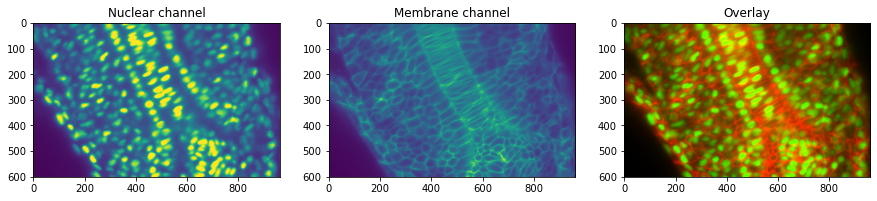

In [3]:
# select index for displaying
idx = 0

# plot the data
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(X_total[idx, ..., 0])
ax[1].imshow(X_total[idx, ..., 1])
ax[2].imshow(plot.image_to_rgb(X_total[idx,:,:,:], channels = [2,1]))

ax[0].set_title('Nuclear channel')
ax[1].set_title('Membrane channel')
ax[2].set_title('Overlay')

plt.show()

In [23]:
import extCellpose
import importlib
importlib.reload(extCellpose)

# make a prediction using cellpose, then compare overlay with the prediction on top
# maybe use show_segmentation function
#model = models.Cellpose(gpu=True, model_type='cyto')
#model = models.Cellpose(gpu=True, model_type='cyto2') #makes more default segmentations, but lines are not as crisp as cyto

model = extCellpose.extCellpose(gpu=True, model_type='cyto2') # model = Cellpose object = a class inside models.py
model.writeSomething()

nucModel = extCellpose.extCellpose(gpu=True, model_type='nuclei')

#model_new = models.CellposeModel(gpu=True, model_type='tissuenet') #doesn't get the membranes very well even with higher flow.
# tissuenet really feels more like a nuclear segmentator

testing print function inside of inherited class!

testing print function inside of inherited called class CellposeModel in extCellpose!



In [9]:
importlib.reload(extCellpose)
chan = [2,1]
nucChan = [1,0]
#diam=47 # open image in FIJI, draw line segment on a median sized cell, analyze > measure to get pixel count
img = X_total

# to determine min size, zoom in using napari and count pixels of what you think a reasonable cell is

# nuclear segmentation uses cellpose 3D (averages over flows in each direction) because it's good enough to get nuclei
nucMasks, nucFlows, nucStyles, _ = nucModel.eval(img, flow_threshold = 0.2, do_3D=True, \
                                             z_axis = 0, min_size = 30, channels=nucChan) 

#masks, flows, styles, _ = model.eval(img, diameter=diam, flow_threshold = 0.6, do_3D=True, \
#                                             z_axis = 0, channels=chan, min_size = 20)

# takes 4m15s to run on lab computer, single timepoint, 335x601x961

np.save(outputFolder+'output_nuc_masks.npy', nucMasks)
np.save(outputFolder+'output_nuc_outlines.npy',utils.masks_to_outlines(nucMasks))

inside _run_cp in inherited cp


In [24]:
# cytoplasm segmentation uses cellpose 2D and stitches masks together using a custom stitch3D and eval loop
masks, flows, styles, _ = model.eval(img, flow_threshold = 0.2, do_3D=False, \
                                             z_axis = 0, stitch_threshold=0.4, channels=chan) 
#using stitch3D because XZ plane looks much better than other orthogonal views

np.save(outputFolder+'output_masks.npy', masks)
np.save(outputFolder+'output_outlines.npy',utils.masks_to_outlines(masks))

inside _run_cp in inherited cp
currently in newly defined stitch3D!

before modification, istitch= [  1   2   1   3   1   4   5   6   7   8   1   1  10   1  11  13  14  15
   1   1  16  17  18  19   1  22  23  24  25  26  27  29  30  31  32   1
  33   1  35  36  38  40  39  41  42  43  44  45  46  47  48   1  50  49
  51   1  52  53  54  55  56  57  58  59  60  61  62  63  65   1  66  67
  68  70  69  71  72  73  74  76  75  77  78  80  81  83  84  86  87  89
  90   1  92  94  95  96  97  98 100 101 102 103 104   1   1 107 106   1
 109 108 110 111 113 112 114 116 117 118 120 121 122 123 124 126 125 128
 127 131 130 129 132 133 134   1 136 135   1 137 138 139 140 142 143 146
 147 149 150 151 153 154 155   1   1   1 156]
np.arange =  [157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174
 175 176 177 178]
iou shape = (new masks cells, old mask cells) =  (155, 156)
in else clause: istitch shape =  (156,) ino shape =  (22,)
ino= [  2   4  10  11  13  18  19  24  35  37  5

before modification, istitch= [476 510 477   2 343 491 344 511 158   8   1 512   1 181 433   1 514 298
   1 184 493   1 301 384 478 494 435 302 517   1 495 208 387 518 346 264
 364 328 266 479 519   1 496  38 456 329  45 288 497 520 414 393 415 498
 289 416 417 269  63   1  61 251 308 307 436 521 418 459   1  69  66 420
  76 480   1 523 524   1 525 438 461 526 462 367 501 483 396 440   1 441
   1   1 502 484 527 424   1 485 398 331   1 399 311 465 444 503 467 370
 350 216 104 468 402 373 351 531 530 313   1   1 504 532 377 116 533 446
 469 428 448 427 429 316 449 534 318 487 317 430 488 506 174 408 139 140
   1 535 536 341 359]
np.arange =  [538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555
 556]
iou shape = (new masks cells, old mask cells) =  (149, 537)
in else clause: istitch shape =  (150,) ino shape =  (19,)
ino= [ 10  12  15  18  21  29  41  59  68  74  77  88  90  91  96 100 118 119
 144]
after modification, istitch= [  0 476 510 477   2 343 491 344 511 158

Traceback (most recent call last):
  File "C:\Users\atata\anaconda3\envs\cellpose\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\atata\AppData\Local\Temp\ipykernel_9944\3268372103.py", line 2, in <cell line: 2>
    masks, flows, styles, _ = model.eval(img, flow_threshold = 0.2, do_3D=False, \
  File "C:\Users\atata\anaconda3\envs\cellpose\lib\site-packages\cellpose\models.py", line 238, in eval
    masks, flows, styles = self.cp.eval(x,
  File "C:\Users\atata\anaconda3\envs\cellpose\lib\site-packages\cellpose\models.py", line 551, in eval
    masks, styles, dP, cellprob, p = self._run_cp(x,
  File "C:\Users\atata\projects_old\projects\ZebrafishSegmentation\extCellpose.py", line 268, in _run_cp
    nucMasks = self.readMaskFile('output_nuc_masks.npy')
  File "C:\Users\atata\projects_old\projects\ZebrafishSegmentation\extCellpose.py", line 61, in readMaskFile
    return np.load(filename)
  

In [ ]:
importlib.reload(extCellpose)
print(np.shape(nucMasks)) # (Z x X x Y) array of ints (0, 1, 2, ... #cells-1)
print(np.shape(utils.masks_to_outlines(nucMasks))) # (Z x X x Y) array of bools
#print(nucMasks[0,0,:])
#print(utils.masks_to_outlines(nucMasks[0,:,:]))

A = model.cp.calcNumOfNucPerCell(nucMasks, masks)
#print(A)

# need to get the centroids of masks in 2D and 3D
mask2D = masks[0]
mask3D = masks
print(np.shape(mask2D))
print(np.shape(mask3D))

centroids2D = np.zeros([len(np.unique(mask2D)),2])
for i in np.unique(mask2D):
    # compute center of mass of elements in mask with same value as i
    x_centroid, y_centroid = np.argwhere(mask2D == i).mean(0)
    centroids2D[i] = [x_centroid, y_centroid]
    
print(np.shape(centroids2D))
    
centroids3D = np.zeros([len(np.unique(mask3D)),3])
for i in np.unique(mask3D): #takes a few seconds for numPlanes = 20, but maybe not a bottleneck
    z = 0
    while (centroids3D[i,2] == 0 and z < np.shape(mask3D)[0]):
        if (np.sum(mask3D[z] == i) > 0):
            x_centroid, y_centroid = np.argwhere(mask3D[z] == i).mean(0)
            centroids3D[i] = [x_centroid, y_centroid, z]
            break
        else:
            z+= 1

In [ ]:
from cellpose import metrics
mask1 = nucMasks[50,:,:]
mask2 = nucMasks[60,:,:]
plt.figure()
plt.imshow(mask1, cmap='Greys')
plt.figure()
ax2 = plt.imshow(mask2, cmap='Greys')
mask3 = metrics._label_overlap(mask1,mask2)
plt.figure()
print(np.shape(mask3))
overlaps = mask3/mask3
overlaps[np.isnan(overlaps)] = 0
numNucsInCell = np.sum(overlaps,axis=0)
numNucsInCell[numNucsInCell > 10] = 0
print(np.shape(numNucsInCell))


In [ ]:
img_4D = io.imread("WT_data_sample_movie_3-1_single_timepoint.tif")[start:start+numPlanes,0,:,:]
img_nuc4D = io.imread("WT_data_sample_movie_3-1_single_timepoint.tif")[start:start+numPlanes,1,:,:]
masks = np.load(outputFolder + "output_nuc_masks.npy") # you may need imread if these are tiffs 
outlines = np.load(outputFolder + "output_nuc_outlines.npy") # you may need imread if these are tiffs 

viewer = napari.Viewer() 
viewer.add_image(img_4D)
viewer.add_image(img_nuc4D) 
viewer.add_labels(masks) 
viewer.add_labels(outlines)

In [ ]:
print(np.shape(img_4D))
print(np.shape(masks))


In [ ]:
print(np.shape(img))

In [26]:
print(np.array([]))

[]
